### INFO284 Machine Learning Exam, spring 2024

#### Importing and versioncontrol for relevant libraries

In [350]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
pandas version: 2.1.1
matplotlib version: 3.7.2
NumPy version: 1.25.2
SciPy version: 1.11.2
IPython version: 8.12.0
scikit-learn version: 1.3.1


In [351]:
import pandas as pd
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
#keep in mind that the file is encoded in UTF-8, so it will only work if you have the correct version of pandas.
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(df.isna().sum())
df.info()

#excluding columns not relevant for our features
df = df[['Melding ID','Art - gruppe','Meldingsdato','Starttidspunkt','Havdybde start','Havdybde stopp','Rundvekt', "Art - FDIR"]]
df.head()
#taking note of the coloumns with missing values
print("Number of rows: ", df.shape[0])


Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)      2001
Hovedområde start             4124
Lokasjon start (kode)         2001
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)      1962
Hovedområde stopp             4124
Lokasjon stopp (kode)         1962
Havdybde stopp                   0
Trekkavstand                    24
Redskap FAO (kode)               0
Redskap FAO                    188
Redskap FDIR (kode)            188
Redskap FDIR        

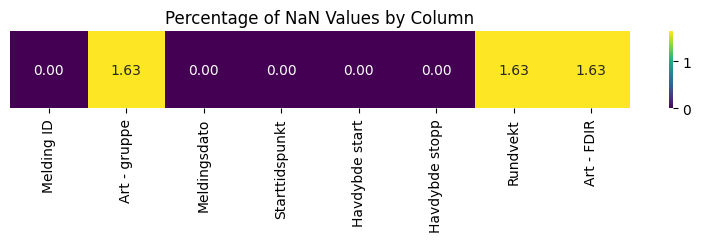

In [352]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate the percentage of NaNs for each column
nanPercentage = df.isna().mean() * 100

nanPercentageDf = pd.DataFrame(nanPercentage.values.reshape(1, -1), columns=df.columns)

# Plotting the heatmap
plt.figure(figsize=(10, 1)) 
sns.heatmap(nanPercentageDf, annot=True, fmt=".2f", cmap="viridis", cbar=True)
plt.title("Percentage of NaN Values by Column")
plt.yticks([])

plt.show()

#this is for looking at the nanvalues in the dataset and how much of the dataset is missing of our specific columns. 

In [353]:
#checking every column for missing values and nan values
#print(df.isnull().sum())
print(df.isna().sum(), "\n")
print(df.isnull().sum())
#the 0 values and nan values are being counted the same as the nan values. So it wont be any collissions between the two. Assuming I can safely remove them

#removing the rows with missing values
df = df.dropna()
df.info()
print(df.isna().sum())
df.head()
print("Number of rows: ", df.shape[0])
df.head()

Melding ID           0
Art - gruppe      4982
Meldingsdato         0
Starttidspunkt       0
Havdybde start       0
Havdybde stopp       0
Rundvekt          4978
Art - FDIR        4982
dtype: int64 

Melding ID           0
Art - gruppe      4982
Meldingsdato         0
Starttidspunkt       0
Havdybde start       0
Havdybde stopp       0
Rundvekt          4978
Art - FDIR        4982
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 300452 entries, 0 to 305433
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Melding ID      300452 non-null  int64  
 1   Art - gruppe    300452 non-null  object 
 2   Meldingsdato    300452 non-null  object 
 3   Starttidspunkt  300452 non-null  object 
 4   Havdybde start  300452 non-null  int64  
 5   Havdybde stopp  300452 non-null  int64  
 6   Rundvekt        300452 non-null  float64
 7   Art - FDIR      300452 non-null  object 
dtypes: float64(1), int64(3), object(4)

,Melding ID,Art - gruppe,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Rundvekt,Art - FDIR
0,1497177,Antarktisk krill,01.01.2018,31.12.2017,-2740,-805,706714.0,Antarktisk krill
1,1497178,Hyse,01.01.2018,30.12.2017 23:21,-335,-334,9594.0,Hyse
2,1497178,Torsk,01.01.2018,30.12.2017 23:21,-335,-334,8510.0,Torsk
3,1497178,Blåkveite,01.01.2018,30.12.2017 23:21,-335,-334,196.0,Blåkveite
4,1497178,Sei,01.01.2018,30.12.2017 23:21,-335,-334,134.0,Sei


In [354]:
#counting total values of art gruppe
print(df['Art - gruppe'].value_counts() , "\n")
#counting total values of art fdir
print(df['Art - FDIR'].value_counts())

Art - gruppe
Torsk                                       56574
Annen torskefisk                            45286
Sei                                         42557
Hyse                                        39120
Annen flatfisk, bunnfisk og dypvannsfisk    25267
Uer                                         19681
Steinbiter                                  16181
Dypvannsreke                                13678
Blåkveite                                    8046
Snøkrabbe                                    6070
Sild, annen                                  6006
Skater og annen bruskfisk                    4067
Makrell                                      3013
Kolmule                                      2843
Øyepål                                       2210
Annen pelagisk fisk                          1802
Vassild og strømsild                         1650
Andre skalldyr, bløtdyr og pigghuder         1329
Lodde                                        1188
Tobis og annen sil                   

In [355]:
#finding out the difference between Art- gruppe and Art - FDIR
print(df['Art - gruppe'].unique(), "\n")
print(df['Art - FDIR'].unique())


['Antarktisk krill' 'Hyse' 'Torsk' 'Blåkveite' 'Sei' 'Steinbiter'
 'Annen flatfisk, bunnfisk og dypvannsfisk' 'Uer' 'Snøkrabbe'
 'Annen torskefisk' 'Andre skalldyr, bløtdyr og pigghuder' 'Dypvannsreke'
 'Skater og annen bruskfisk' 'Øyepål' 'Brunalger' 'Haifisk' 'Kystbrisling'
 'Sild, annen' 'Makrell' 'Annen pelagisk fisk' 'Vassild og strømsild'
 'Kolmule' 'Kongekrabbe, annen' 'Lodde' 'Sjøpattedyr' 'Mesopelagisk fisk'
 'Tunfisk og tunfisklignende arter' 'Taskekrabbe' 'Tobis og annen sil'
 'Raudåte'] 

['Antarktisk krill' 'Hyse' 'Torsk' 'Blåkveite' 'Sei' 'Flekksteinbit'
 'Kveite' 'Snabeluer' 'Uer (vanlig)' 'Rødspette' 'Snøkrabbe' 'Lange'
 'Blåsteinbit' 'Breiflabb' 'Akkar' 'Hvitting' 'Lysing' 'Brosme'
 'Annen marin fisk' 'Antarktisk tannfisk' 'Steinbiter' 'Dypvannsreke'
 'Skate, uspes.' 'Reke av  Pandalusslekten' 'Øyepål' 'Smørflyndre'
 'Stortare' 'Annen skate og rokke' 'Lyr' 'Sjøkreps'
 'Vanlig ti-armet blekksprut, uspes.' 'Pigghå' 'Pink cusk-eel *'
 'Glassvar' 'Brisling' 'Isgalt' 'Gråst

In [356]:
#checking if other will be overrepresented in the dataset
other_sum = df[~df['Art - gruppe'].isin(['Torsk', 'Sei', 'Hyse'])].shape[0]
print("Sum of others: ", other_sum)
#counting torsk sei and hyse
print(df['Art - gruppe'].value_counts())
#it definitely will be overrepresented in the dataset. Do we want to remove it? It will certainly add model complexity.

Sum of others:  162201
Art - gruppe
Torsk                                       56574
Annen torskefisk                            45286
Sei                                         42557
Hyse                                        39120
Annen flatfisk, bunnfisk og dypvannsfisk    25267
Uer                                         19681
Steinbiter                                  16181
Dypvannsreke                                13678
Blåkveite                                    8046
Snøkrabbe                                    6070
Sild, annen                                  6006
Skater og annen bruskfisk                    4067
Makrell                                      3013
Kolmule                                      2843
Øyepål                                       2210
Annen pelagisk fisk                          1802
Vassild og strømsild                         1650
Andre skalldyr, bløtdyr og pigghuder         1329
Lodde                                        1188
Tobis og annen

In [357]:
#counting number of rows
print("Number of rows: ", df.shape[0])
#realising that i havent dropped any rows since the number of rows are still the same
df.dropna(inplace=True)
print("New number of rows: ", df.shape[0])
#actually gonna drop all rows other than torsk, sei, hyse. Since we are only interested in these three species. The other are underrepresented and not relevant for our analysis.
df = df[df['Art - gruppe'].isin(['Torsk', 'Sei', 'Hyse'])]
print("Only focusing on torsk sei hyse: ", df.shape[0])
df.head()
#so now we are working with %{df}.


Number of rows:  300452
New number of rows:  300452
Only focusing on torsk sei hyse:  138251


,Melding ID,Art - gruppe,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Rundvekt,Art - FDIR
1,1497178,Hyse,01.01.2018,30.12.2017 23:21,-335,-334,9594.0,Hyse
2,1497178,Torsk,01.01.2018,30.12.2017 23:21,-335,-334,8510.0,Torsk
4,1497178,Sei,01.01.2018,30.12.2017 23:21,-335,-334,134.0,Sei
5,1497178,Hyse,01.01.2018,31.12.2017 05:48,-403,-277,9118.0,Hyse
6,1497178,Torsk,01.01.2018,31.12.2017 05:48,-403,-277,6651.0,Torsk


In [358]:

#comparing art-gruppe and art-fdir to see if they are the same, counting the values
print(df['Art - gruppe'].value_counts(), "\n")
print(df['Art - FDIR'].value_counts())
#they are the same, so we can remove one of the columns.
#removing fdir
df = df.drop(columns=['Art - FDIR'])
df.head()

Art - gruppe
Torsk    56574
Sei      42557
Hyse     39120
Name: count, dtype: int64 

Art - FDIR
Torsk    56574
Sei      42557
Hyse     39120
Name: count, dtype: int64


,Melding ID,Art - gruppe,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Rundvekt
1,1497178,Hyse,01.01.2018,30.12.2017 23:21,-335,-334,9594.0
2,1497178,Torsk,01.01.2018,30.12.2017 23:21,-335,-334,8510.0
4,1497178,Sei,01.01.2018,30.12.2017 23:21,-335,-334,134.0
5,1497178,Hyse,01.01.2018,31.12.2017 05:48,-403,-277,9118.0
6,1497178,Torsk,01.01.2018,31.12.2017 05:48,-403,-277,6651.0


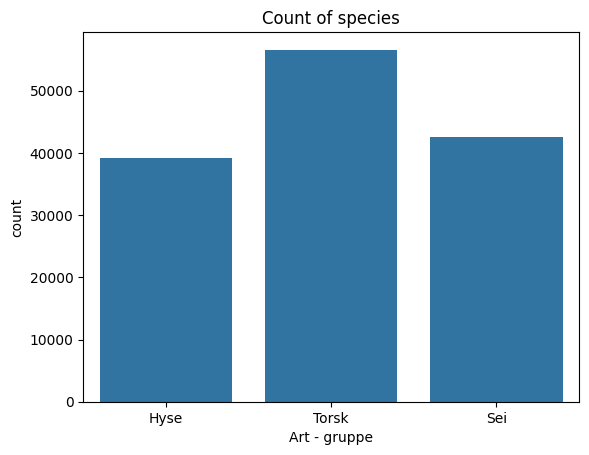

In [359]:
#presenting the count of the different species in the dataset with a barplot
sns.countplot(x='Art - gruppe', data=df)
plt.title('Count of species')
plt.show()

In [360]:
#counting the unique number of boats
print(df['Melding ID'].unique())

[1497178 1497229 1497288 ... 1800285 1800286 1800291]


<Axes: xlabel='Havdybde start', ylabel='Havdybde stopp'>

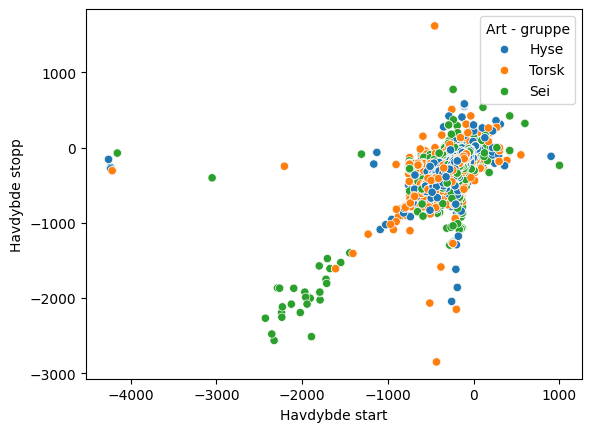

In [361]:
#plotting havdybde start and havdybde stopp using seaborn with different color for each species
sns.scatterplot(x='Havdybde start', y='Havdybde stopp', data=df, hue='Art - gruppe')
#viewing the plot and seeing it is so dense that it is hard to see the differences between the species. Additionally there are a lot of species over 0 which does not make sense when fishing.

#maybe we should use a threshold for the depth, since it is not possible to fish at 0 depth?
#then we will loose a lot of data points, so maybe there is a way to transform the outliers?
#But then again the transformed outliers will be useless since the initial values are not reliable? Are depth feature even reliable?


#note: Should probably transform the Art-gruppe to numerical values with one hot encoding.

In [362]:
#pivoting the rows where all the meldingspunkt are identical on the same row including all the species
df = df.pivot_table(index=['Melding ID', 'Meldingsdato', 'Starttidspunkt', 'Havdybde start', 'Havdybde stopp'], columns='Art - gruppe', values='Rundvekt', aggfunc='sum').reset_index()
df = df.fillna(0) # filling Nan values with 0
print("Number of rows: ", df.shape[0])
df.head()


Number of rows:  65611


Art - gruppe,Melding ID,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Hyse,Sei,Torsk
0,1497178,01.01.2018,30.12.2017 23:21,-335,-334,9594.0,134.0,8510.0
1,1497178,01.01.2018,31.12.2017 05:48,-403,-277,9118.0,67.0,6651.0
2,1497178,01.01.2018,31.12.2017 11:34,-346,-496,12432.0,68.0,5097.0
3,1497178,01.01.2018,31.12.2017 17:44,-443,-358,6758.0,0.0,7022.0
4,1497229,01.01.2018,01.01.2018 10:01,-71,-56,4.0,0.0,0.0


#### Current thoughts:
How will we treat outliers and all above 0 depth?

In [363]:
#removing all rows where the depth is greater than -1
df = df[df['Havdybde start'] <= -1]
df = df[df['Havdybde stopp'] <= -1]

#now counting the number of rows
print("Number of rows: ", df.shape[0])
df.info()
df.head()

Number of rows:  65199
<class 'pandas.core.frame.DataFrame'>
Index: 65199 entries, 0 to 65610
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Melding ID      65199 non-null  int64  
 1   Meldingsdato    65199 non-null  object 
 2   Starttidspunkt  65199 non-null  object 
 3   Havdybde start  65199 non-null  int64  
 4   Havdybde stopp  65199 non-null  int64  
 5   Hyse            65199 non-null  float64
 6   Sei             65199 non-null  float64
 7   Torsk           65199 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 4.5+ MB


Art - gruppe,Melding ID,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Hyse,Sei,Torsk
0,1497178,01.01.2018,30.12.2017 23:21,-335,-334,9594.0,134.0,8510.0
1,1497178,01.01.2018,31.12.2017 05:48,-403,-277,9118.0,67.0,6651.0
2,1497178,01.01.2018,31.12.2017 11:34,-346,-496,12432.0,68.0,5097.0
3,1497178,01.01.2018,31.12.2017 17:44,-443,-358,6758.0,0.0,7022.0
4,1497229,01.01.2018,01.01.2018 10:01,-71,-56,4.0,0.0,0.0


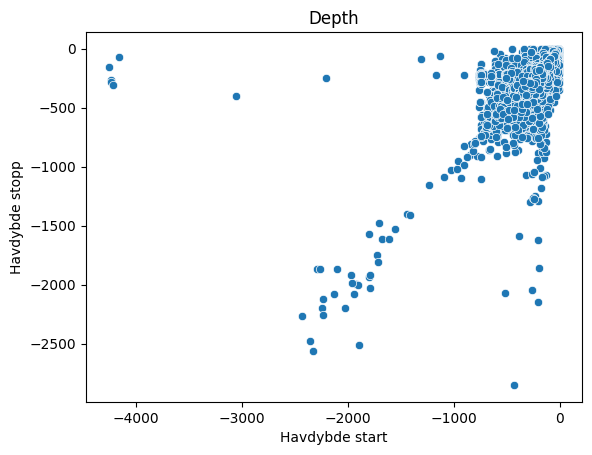

Art - gruppe,Melding ID,Meldingsdato,Starttidspunkt,Havdybde start,Havdybde stopp,Hyse,Sei,Torsk,Total
0,1497178,01.01.2018,30.12.2017 23:21,-335,-334,9594.0,134.0,8510.0,18238.0
1,1497178,01.01.2018,31.12.2017 05:48,-403,-277,9118.0,67.0,6651.0,15836.0
2,1497178,01.01.2018,31.12.2017 11:34,-346,-496,12432.0,68.0,5097.0,17597.0
3,1497178,01.01.2018,31.12.2017 17:44,-443,-358,6758.0,0.0,7022.0,13780.0
4,1497229,01.01.2018,01.01.2018 10:01,-71,-56,4.0,0.0,0.0,4.0


In [368]:
#plotting depth
sns.scatterplot(x='Havdybde start', y='Havdybde stopp', data=df)
plt.title('Depth')
plt.show()

#summing all the species to get the total weight of the catch
df['Total'] = df['Hyse'] + df['Sei'] + df['Torsk']
df.head()


#### This was more about learning about group function, aggregate and then concluding with pivot function will be most relevant


In [365]:
#rows where Melding ID, Starttidspunkt are identical it's actually the same boat just casting different lines from the fishingboat
#We would have to transform data to represent the sameboat on a single row
#Each row with the same mentioned columns, are representing each row with a different fish. So they use rows to represent the same boat, but different fish
""" grouped = df.groupby(['Melding ID', 'Starttidspunkt', 'Startklokkeslett'])
print(grouped.size()) """
#realising its enough to group by Meldings ID
#grouped = df.groupby(['Melding ID', 'Meldingsdato','Starttidspunkt'])
#print(grouped.size())

#now I would have to aggregate the data where the size is greater than 1 into a single row, but also represent all the different fish in the same row
#Since the fish are in each of their own rows orginally, The new row would have to represent all the fish in the same row, with each fish in their own column
#I would have to use the pivot function to do this?  Trying with pivot


#now I want to aggregate the data where the size is greater than 1 into a single row
#code for this would be
aggFunctions = {'Melding ID':'first','Starttidspunkt':'first', 'Meldingsdato':'first', 'Art - gruppe':'first', 'Havdybde start':'first', 'Havdybde stopp':'first', 'Rundvekt':'sum', 'Art - FDIR':'first'}

#dfNew = df.groupby(['Melding ID', 'Starttidspunkt']).agg(aggFunctions)
#transforming each group into a single row
#print(dfNew.head())

""" aggFunctions = {'Melding ID':'first','Starttidspunkt':'first', 'Meldingsdato':'first', 'Art - gruppe':'first', 'Havdybde start':'first', 'Havdybde stopp':'first', 'Rundvekt':'sum', 'Art - FDIR':'first'}

dfNew = df.groupby('Melding ID','Starttidspunkt').agg(aggFunctions)
#transforming each group into a single row
print(dfNew.head()) """

" aggFunctions = {'Melding ID':'first','Starttidspunkt':'first', 'Meldingsdato':'first', 'Art - gruppe':'first', 'Havdybde start':'first', 'Havdybde stopp':'first', 'Rundvekt':'sum', 'Art - FDIR':'first'}\n\ndfNew = df.groupby('Melding ID','Starttidspunkt').agg(aggFunctions)\n#transforming each group into a single row\nprint(dfNew.head()) "

#### This was more about solving the row problems

In [366]:
grouped = dfNew.groupby(['Melding ID', 'Meldingsdato', 'Starttidspunkt'])
print(dfNew.grouped.size())

#realsing that the same boat is fishing further down in dataset, so we have to group differently.
#looking if the same boat gets a new id if its fishing again
""" print(dfNew['Melding ID'].value_counts(),"\n") """
#checking in old dataset
""" print(df['Melding ID'].value_counts()) """
#checking the unique values of the Melding ID in the old dataset
""" print(df['Melding ID'].nunique()) """
#this means its 4937 unique boats in the dataset
#I want to check if the same boat gets a new id if its fishing again
#checking the whole dataset
print(df['Melding ID'].value_counts())
""" Melding ID
1657367    54
1646724    50
1654624    46
1601430    44
1695415    44 """  
#this tells me it keeps the same id
#But then we would have to group by Melding ID, and Start


NameError: name 'dfNew' is not defined

In [ ]:
#realising that the column Art - gruppe is a categorical variable, we can transform it into a one hot encoding
#this will allow us to use the column as a feature for our model
dfNew = pd.get_dummies(dfNew, columns=['Art - gruppe'])
print(dfNew.head())